# Quality Assurance/Quality Control for pH Time Series
## 23 July 2023

In [1]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [128]:
def rmoutliers_STD(dataframe, var):
    # Calculate the upper and lower limits
    # As defined by 2 standard deviations more/less than mean
    STD = dataframe[var].std()
    MN = dataframe[var].mean()
    LOWER = MN - 2*STD
    UPPER = MN + 2*STD

    for ind in dataframe.index:
        if dataframe[var][ind] > UPPER:
            dataframe = dataframe.drop(ind)
        elif dataframe[var][ind] < LOWER:
            dataframe = dataframe.drop(ind)
    df = dataframe.reset_index(drop=True)
    
    return df

# Get data

1. Hydrocat 620 (`hydrocat620`): Davies buoy at Jamestown/PLT
2. Hydrocat 720 (`hydrocat720`): Davies buoy at Greenwich Bay/GB
3. MV (`MV`): Narr Bay Fixed Station Monitoring Network at Mt. View near GB
4. QP (`QP`): Narr Bay Fixed Station Monitoring Network at Quonset Pt near PLT
5. Lab data (`labdf`): TA [umol/kg], DIC [umol/kg], and pH from all lab samples (i.e. from both PLT and GB)
6. SeaFET sensor (`seafet`): Wang buoy near PLT, data held locally

In [3]:
hydrocat620 = PLT.get_hydrocat('2021-01-01', '2023-06-10', 'PLT')
hydrocat720 = PLT.get_hydrocat('2021-01-01', '2023-06-10', 'GB')
MV = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1fK_lYz7PiTGOt7UZanFDcQ0H8WAhbiujo3i07f4lnHE/edit#gid=813729054', 'MV')
QP = PLT.get_NBFSMN('https://docs.google.com/spreadsheets/d/1wxT4mjgoYmTZCqTRGAYsIrs6LKyT1aI4pPpqZFIqyfw/edit#gid=2053781657','QP')

In [4]:
labdf = PLT.get_lab_samples('https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=0.', 'Sheet1')

# merge datasets by time

- convert datetime to timestamp

- add ordinal time

- merge!

In [5]:
hydrocat620["time"] = pd.to_datetime(hydrocat620['DateTime'])
hydrocat720["time"] = pd.to_datetime(hydrocat720['DateTime'])
MV["time"] = pd.to_datetime(MV['DateTime'])
QP["time"] = pd.to_datetime(QP['DateTime'])
labdf["time"] = pd.to_datetime(labdf['DateTime'])

In [6]:
hydrocat620['ordinal_time'] = np.zeros(len(hydrocat620['time']))
hydrocat720['ordinal_time'] = np.zeros(len(hydrocat720['time']))
MV['ordinal_time'] = np.zeros(len(MV['time']))
QP['ordinal_time'] = np.zeros(len(QP['time']))
labdf['ordinal_time'] = np.zeros(len(labdf['time']))
for i in hydrocat620.index:
    hydrocat620['ordinal_time'][i] = hydrocat620['time'][i].toordinal()
for j in hydrocat720.index:
    hydrocat720['ordinal_time'][j] = hydrocat720['time'][j].toordinal()
for k in MV.index:
    MV['ordinal_time'][k] = MV['time'][k].toordinal()
for l in QP.index:
    QP['ordinal_time'][l] = QP['time'][l].toordinal()
for m in labdf.index:
    if m != 71:
        labdf['ordinal_time'][m] = labdf['time'][m].toordinal()

In [7]:
labGB = labdf.where(labdf['Location']== 'GB').dropna()
labPLT = labdf.where(labdf['Location']== 'PLT').dropna()
labGB = labGB.reset_index(drop=True)
labPLT = labPLT.reset_index(drop=True)

In [8]:
hydrocat620 = hydrocat620[['DateTime', 'time', 'ordinal_time', 'hydrocatTemperature', 'hydrocatDissOxygen', 'hydrocatSalinity', 'pH total', 'hydrocatFluorescence']]
hydrocat720 = hydrocat720[['DateTime', 'time', 'ordinal_time', 'hydrocatTemperature', 'hydrocatDissOxygen', 'hydrocatSalinity', 'pH total', 'hydrocatFluorescence']]
MV = MV[['DateTime', 'time', 'ordinal_time','surface Temp', 'surface Salinity', 'surface DO Conc', 'pH total']]
QP = QP[['DateTime', 'time', 'ordinal_time','surface Temp', 'surface Salinity', 'surface DO Conc', 'pH total']]

In [9]:
PLT_hydro620 = pd.merge_asof(labPLT, hydrocat620, on="time",tolerance = pd.Timedelta("45m"))
GB_hydro720 = pd.merge_asof(labGB, hydrocat720, on="time",tolerance = pd.Timedelta("30m"))
GB_MV = pd.merge_asof(labGB, MV, on="time",tolerance = pd.Timedelta("30m"))
PLT_QP = pd.merge_asof(labPLT, QP, on="time",tolerance = pd.Timedelta("30m"))

# QP at PLT site

It seems that QP gas a positive/basic bias after September 20, 2022. Per Hongjie's suggestion, we simply eliminate data after September 20, 2022,.

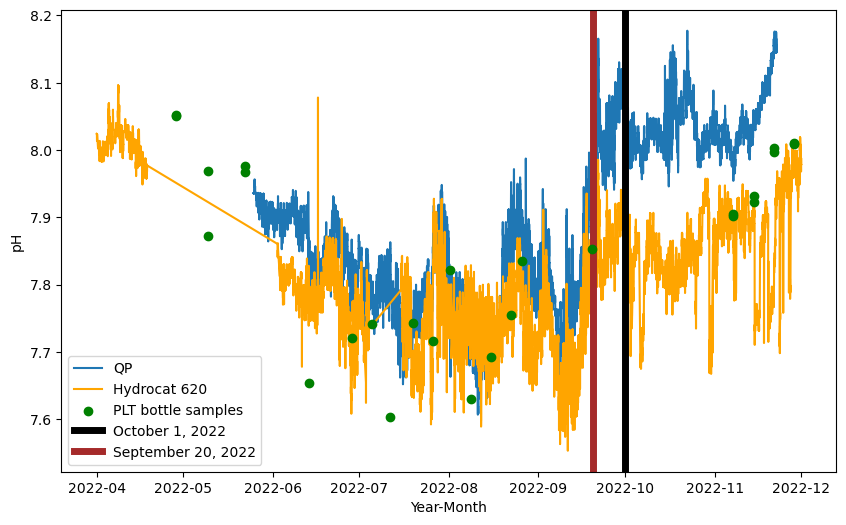

In [32]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(QP['DateTime'], QP['pH total'], label = 'QP')
QP620 = hydrocat620.where(hydrocat620['DateTime'] < datetime(2022,12,1)).where(hydrocat620['DateTime'] > datetime(2022,4,1)).dropna()
ax.plot(QP620['DateTime'], QP620['pH total'], color = 'orange', label = 'Hydrocat 620')
labQP = labPLT.where(labPLT['DateTime'] < datetime(2022,12,1)).dropna()
ax.scatter(labQP['DateTime'], labQP['pH'], color = 'green', label = 'PLT bottle samples', zorder = 3)

ax.axvline(datetime(2022, 10, 1), color = 'k', lw = 5, label = 'October 1, 2022')
ax.axvline(datetime(2022, 9, 20), color = 'brown', lw = 5,label = 'September 20, 2022')

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

## QP corrected
First, only dropping measurements after September 20, 2022.

In [33]:
QP_corrected = QP.where(QP['DateTime'] < datetime(2022,9,20)).dropna()
QP_corrected = QP_corrected.reset_index(drop=True)

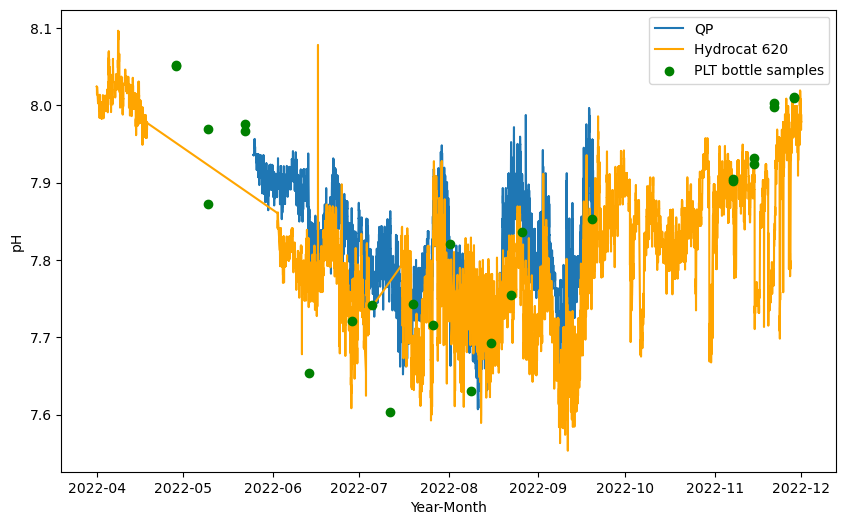

In [34]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(QP_corrected['DateTime'], QP_corrected['pH total'], label = 'QP')
QP620 = hydrocat620.where(hydrocat620['DateTime'] < datetime(2022,12,1)).where(hydrocat620['DateTime'] > datetime(2022,4,1)).dropna()
ax.plot(QP620['DateTime'], QP620['pH total'], color = 'orange', label = 'Hydrocat 620')
labQP = labPLT.where(labPLT['DateTime'] < datetime(2022,12,1)).dropna()
ax.scatter(labQP['DateTime'], labQP['pH'], color = 'green', label = 'PLT bottle samples', zorder = 3)

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

### Difference between sensor and lab pH as a function of time
If we want to correct that data, it does not appear there is a good fit when data is a function of time (ordinal day).

In [35]:
PLT_QP = pd.merge_asof(labPLT, QP_corrected, on="time",tolerance = pd.Timedelta("30m"))

In [36]:
PLT_QP.keys()

Index(['Sample', 'DateTime_x', 'Location', 'depth', 'Salinity',
       'In Situ Temperature', 'DIC (umol/kg)', 'TA (umol/kg)', 'pH', 'time',
       'ordinal_time_x', 'DateTime_y', 'ordinal_time_y', 'surface Temp',
       'surface Salinity', 'surface DO Conc', 'pH total'],
      dtype='object')

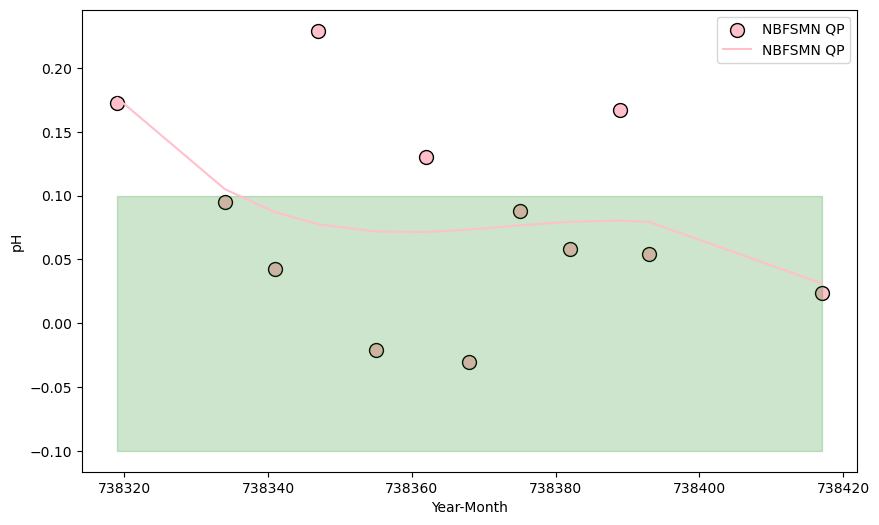

In [43]:
fig, ax = plt.subplots(figsize = [10,6])

PLT_QP_ = PLT_QP.dropna()
ax.scatter(PLT_QP_['ordinal_time_x'],PLT_QP_['pH total'] - PLT_QP_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolor = 'pink', label = 'NBFSMN QP')
pxQP = np.poly1d(np.polyfit(PLT_QP_['ordinal_time_x'], PLT_QP_['pH total'] - PLT_QP_['pH'], 5))
ax.plot(PLT_QP_['ordinal_time_x'], pxQP(PLT_QP_['ordinal_time_x']), 
        color = 'pink', label = 'NBFSMN QP')
ax.fill_between(PLT_QP_['ordinal_time_x'], -0.1, 0.1, color = 'g', alpha = 0.2)

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

### QP corrected by temperature
When plotting the difference between the lab sample pH and sensor pH, we can see that QP does tend to overestimate pH in mid to low summer temperatures. We can model this error using a 5th order polynomial. If we correct this data using the 5th order polynomial, the data matches well.

Text(0, 0.5, 'Sensor pH - Lab Sample pH')

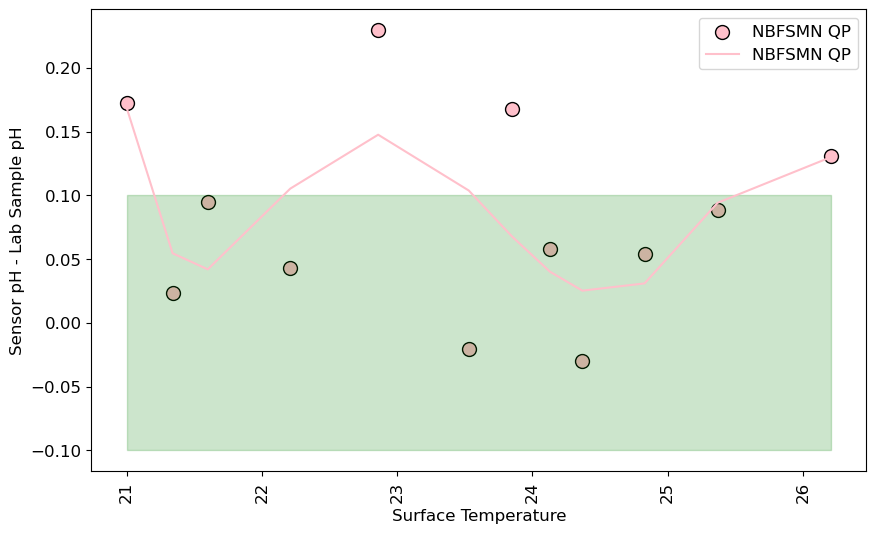

In [64]:
fig, ax = plt.subplots(figsize = [10,6])

PLT_QP_ = PLT_QP.dropna()
PLT_QP_ = PLT_QP_.sort_values(by=['surface Temp'])
ax.scatter(PLT_QP_['surface Temp'],PLT_QP_['pH total'] - PLT_QP_['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolor = 'pink', label = 'NBFSMN QP')
pxQP = np.poly1d(np.polyfit(PLT_QP_['surface Temp'], PLT_QP_['pH total'] - PLT_QP_['pH'], 5))
ax.plot(PLT_QP_['surface Temp'], pxQP(PLT_QP_['surface Temp']), 
        color = 'pink', label = 'NBFSMN QP')
ax.fill_between(PLT_QP_['surface Temp'], -0.1, 0.1, color = 'g', alpha = 0.2)

ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Surface Temperature', fontsize = 12)
ax.set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)


In [50]:
QP_corrected['offset temp'] = np.zeros(len(QP_corrected['ordinal_time']))
for k in QP_corrected.index:
    t = QP_corrected['surface Temp'][k]
    if t > 21 and t < 27 :
        OFFSET = pxQP[0] + pxQP[1] * t + pxQP[2] * t**2 + pxQP[3] * t**3 + pxQP[4] * t**4 + pxQP[5] * t**5 #+ pxQP[6] * t**6 + pxQP[7] * t**7
    else:
        OFFSET = 0
    if np.abs(OFFSET) >= 0.1:
        QP_corrected['offset temp'][k] = OFFSET

QP_corrected['adjusted_ph temp'] = np.zeros(len(QP_corrected['ordinal_time']))
for i in QP_corrected.index:
    QP_corrected['adjusted_ph temp'][i] = QP_corrected['pH total'][i] - QP_corrected['offset temp'][i]

In [61]:
QP_corrected = rmoutliers_STD(QP_corrected, 'adjusted_ph temp')

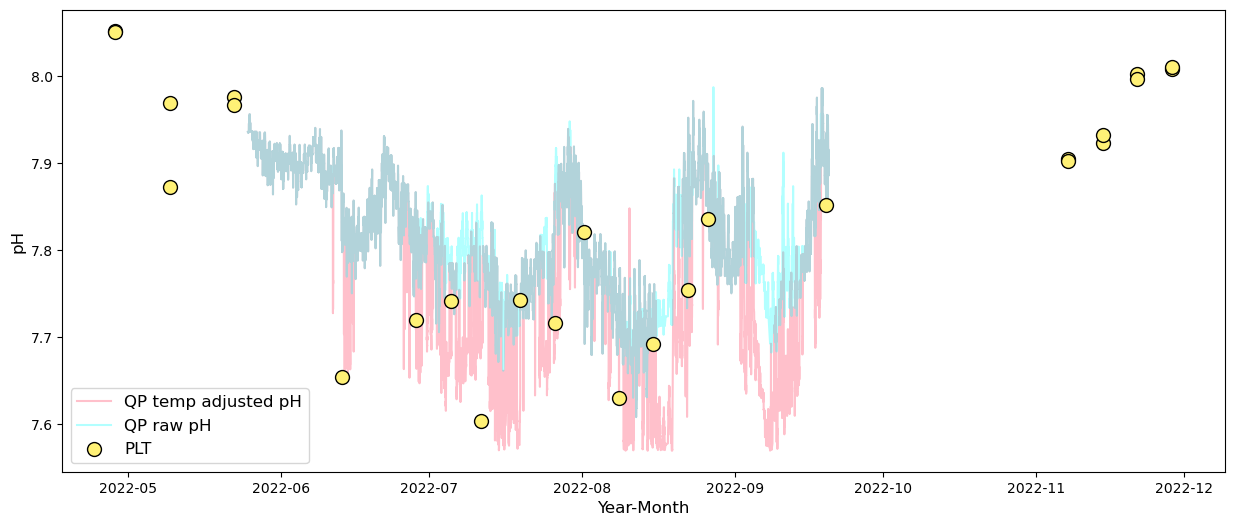

In [62]:
fig, ax = plt.subplots(figsize = [15,6])

ax.plot(QP_corrected['time'], QP_corrected['adjusted_ph temp'], color = 'pink', label = 'QP temp adjusted pH')
ax.plot(QP_corrected['time'], QP_corrected['pH total'], alpha = 0.3, color = 'cyan', label = 'QP raw pH')
ax.scatter(labQP['time'],labQP['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
ax.set_ylabel('pH', fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.legend(fontsize = 12)

### Another correction to QP
I took the mean of all the differnces between sensor pH and lab pH; on average, QP overestimated pH by 0.084. This correct substracts that mean difference from *all* meaurements.

In [162]:
print('Mean difference between QP pH and PLT bottle sample pH = ' + 
      str((PLT_QP_['pH total'] - PLT_QP_['pH']).mean()))

Mean difference between QP pH and PLT bottle sample pH = 0.08424439688175138


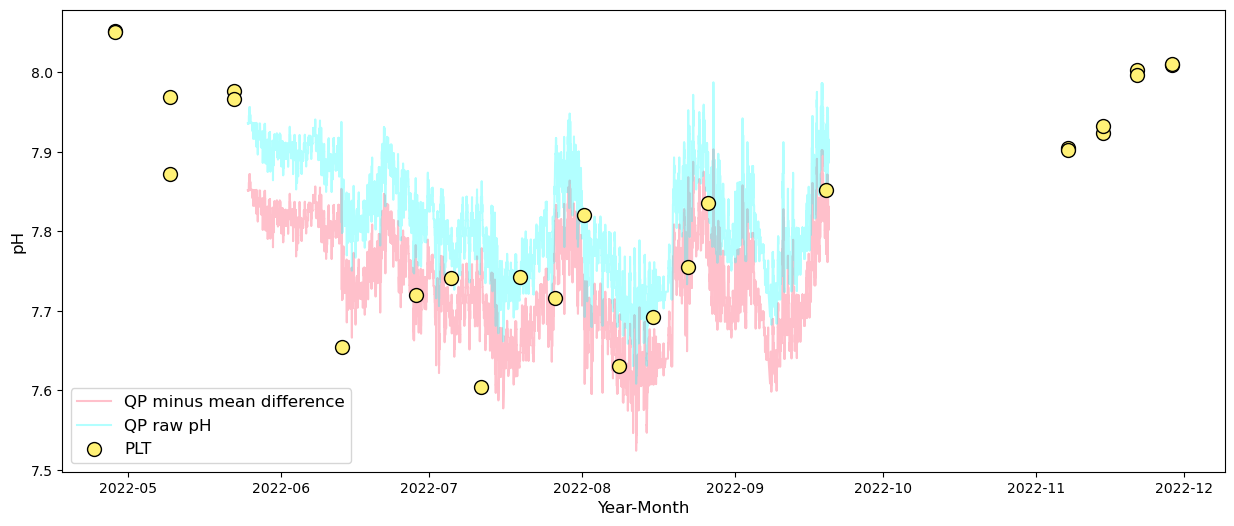

In [163]:
fig, ax = plt.subplots(figsize = [15,6])

ax.plot(QP_corrected['time'], QP_corrected['pH total'] - (PLT_QP_['pH total'] - PLT_QP_['pH']).mean(), color = 'pink', label = 'QP minus mean difference')
ax.plot(QP_corrected['time'], QP_corrected['pH total'], alpha = 0.3, color = 'cyan', label = 'QP raw pH')
ax.scatter(labQP['time'],labQP['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
ax.set_ylabel('pH', fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.legend(fontsize = 12)

@Hongjie, please let me know which method of correction you prefer for this dataset, because I am undecided.

# Hydrocat 620

We already know Hydrocat 620 breaks at the beginning of May 2023, so we can just delete that data. It also isn't very reliable or verifiable prior to 2022, so we also delete 2021 data.

In [67]:
hydrocat620 = hydrocat620.where(hydrocat620['DateTime'] < datetime(2023,5,1)).dropna()
hydrocat620 = hydrocat620.where(hydrocat620['DateTime'] > datetime(2022,1,1)).dropna()
hydrocat620 = hydrocat620.reset_index(drop=True)

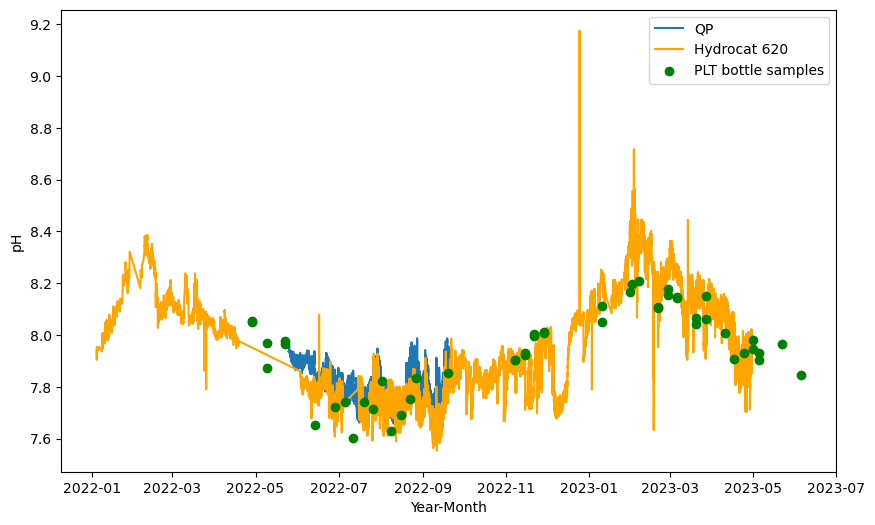

In [68]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(QP_corrected['DateTime'], QP_corrected['pH total'], label = 'QP')
ax.plot(hydrocat620['DateTime'], hydrocat620['pH total'], color = 'orange', label = 'Hydrocat 620')
ax.scatter(labPLT['DateTime'], labPLT['pH'], color = 'green', label = 'PLT bottle samples', zorder = 3)

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

## Hydrocat 620 corrected

There are a few spikes in pH, so I removed pH values 3 standard deviations past the mean. This seemed to remove the spikes.

In [75]:
hydrocat620_corrected = rmoutliers_STD(hydrocat620, 'pH total')

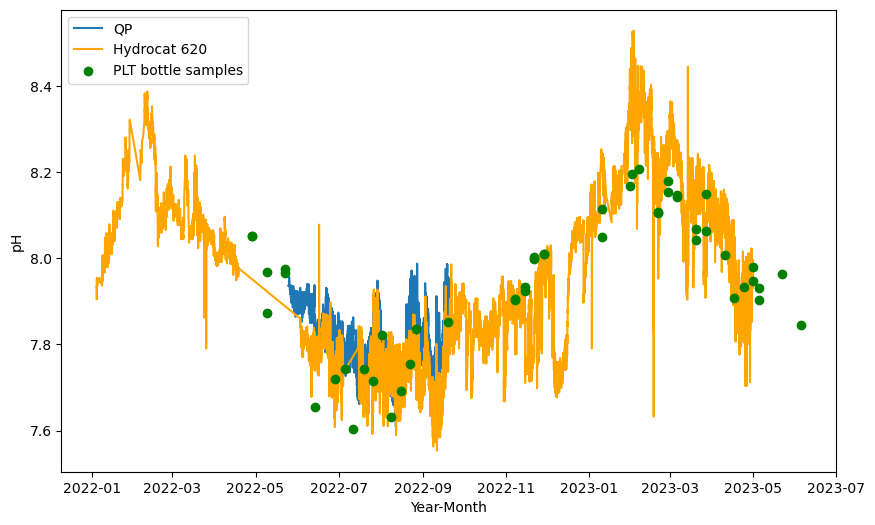

In [76]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(QP_corrected['DateTime'], QP_corrected['pH total'], label = 'QP')
ax.plot(hydrocat620_corrected['DateTime'], hydrocat620_corrected['pH total'], color = 'orange', label = 'Hydrocat 620')
ax.scatter(labPLT['DateTime'], labPLT['pH'], color = 'green', label = 'PLT bottle samples', zorder = 3)

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

### Hydrocat 620 corrected by temperature
Hydrocat 620 shows a basic bias in pH in Jan/Feb/Mar of 2023, which is when temperatures are lowest. Let's try correcting that as a function of temperature. We can apply this correction based on a 3rd order polynomial to only where measurement error is beyond instrument uncertainty and where time of measurement is after Jan 1, 2023.

In [77]:
PLT_hydro620 = pd.merge_asof(labPLT, hydrocat620_corrected, on="time",tolerance = pd.Timedelta("45m"))

(-0.6, 0.6)

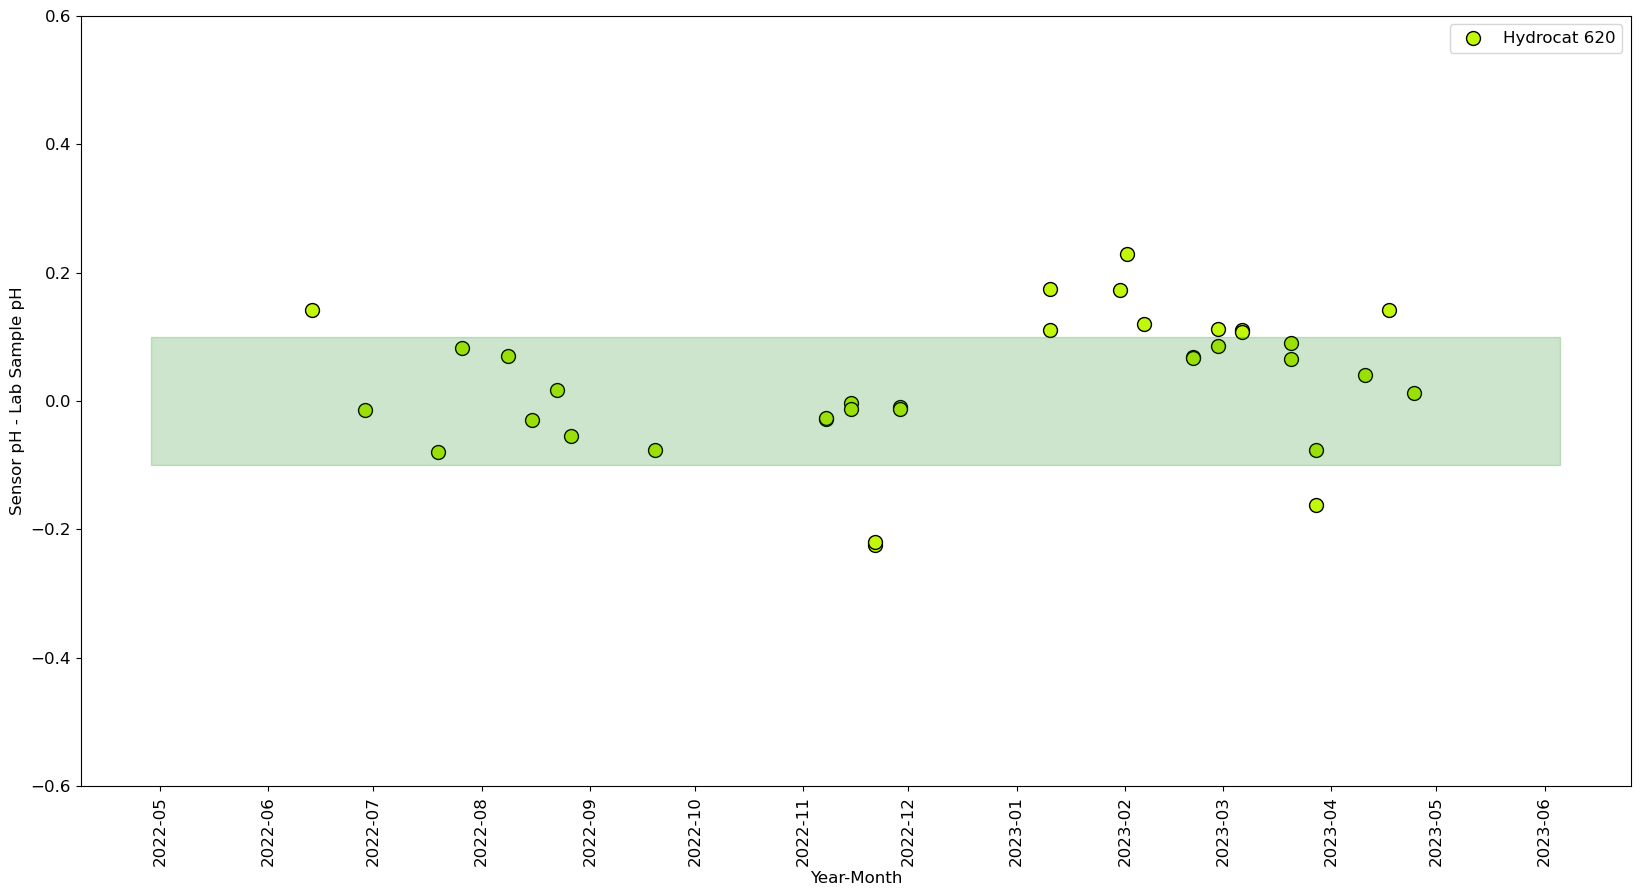

In [78]:
fig, ax = plt.subplots(figsize = [20,10])

ax.scatter(PLT_hydro620['time'],PLT_hydro620['pH total'] - PLT_hydro620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C1F80A', label = 'Hydrocat 620')

ax.fill_between(PLT_hydro620['time'], -0.1, 0.1, color = 'g', alpha = 0.2)
# ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - E*delt, color = 'r', alpha = 0.2)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)
ax.set_ylim([-0.6,0.6])

#### Difference between sensor pH and lab pH as a function of temperature
With a 3rd order polynomial modeling the difference between the pH measurements. As we can see, this model only proposes pH corrections to low temperatures. When applying this correction, I further specify that the modeled correction should only be applied for times after January 2023.

(-0.5, 0.5)

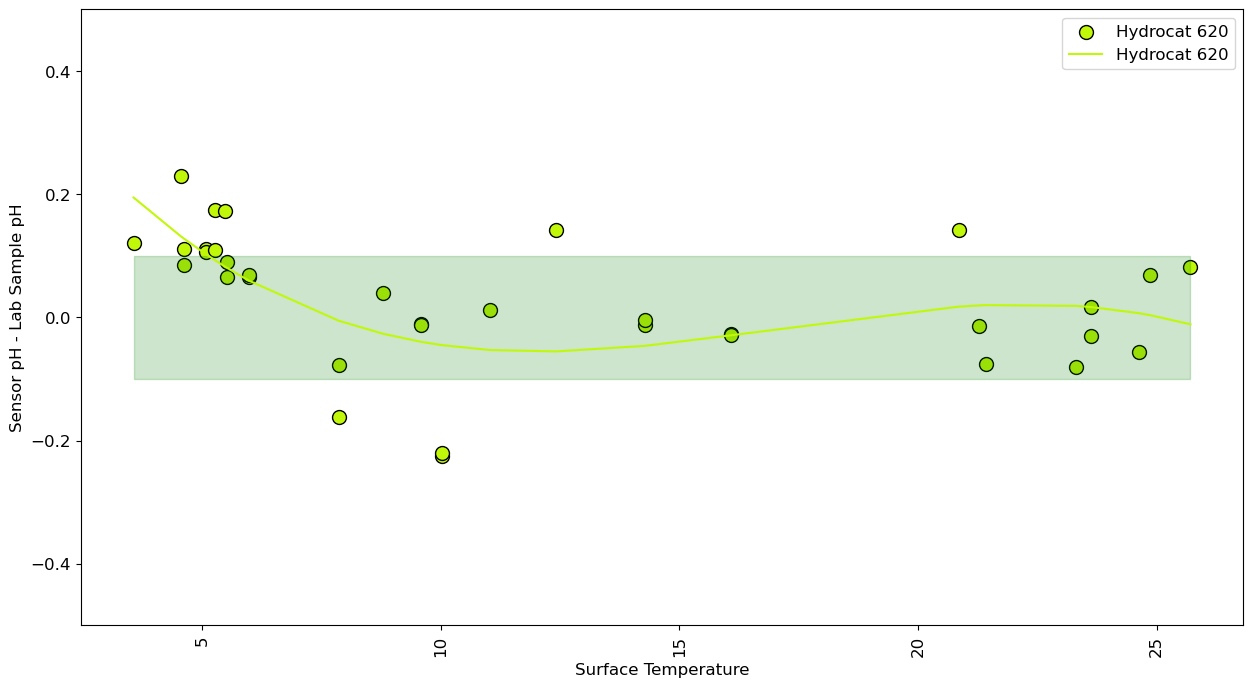

In [79]:
fig, ax = plt.subplots(figsize = [15,8])

PLT_hydrocat620 = PLT_hydro620.dropna()
PLT_hydrocat620 = PLT_hydrocat620.sort_values(by=['hydrocatTemperature'])
ax.scatter(PLT_hydrocat620['hydrocatTemperature'],PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 
           marker = 'o', s = 100, edgecolors = 'k',facecolors = '#C1F80A', label = 'Hydrocat 620')
px620 = np.poly1d(np.polyfit(PLT_hydrocat620['hydrocatTemperature'], PLT_hydrocat620['pH total'] - PLT_hydrocat620['pH'], 3))
ax.plot(PLT_hydrocat620['hydrocatTemperature'], px620(PLT_hydrocat620['hydrocatTemperature']), 
        color = '#C1F80A', label = 'Hydrocat 620')

ax.fill_between(PLT_hydrocat620['hydrocatTemperature'], -0.1, 0.1, color = 'g', alpha = 0.2)
# ax.fill_between(mockX[:,0], mockY[:,0],mockY[:,0] - E*delt, color = 'r', alpha = 0.2)

# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend(fontsize = 12)
ax.set_xlabel('Surface Temperature', fontsize = 12)
ax.set_ylabel('Sensor pH - Lab Sample pH', fontsize = 12)
ax.set_ylim([-0.5,0.5])

In [90]:
hydrocat620_corrected['offset temp'] = np.zeros(len(hydrocat620_corrected['ordinal_time']))
for i in hydrocat620_corrected.index:
    t = hydrocat620_corrected['hydrocatTemperature'][i]
    time = hydrocat620_corrected['DateTime'][i]
    # if t > 738470 and t < 783650:
    if t < 30 and t > 3 and time > datetime(2023,1,1):
        OFFSET = px620[0] + px620[1] * t + px620[2] * t**2 + px620[3] * t**3
        if np.abs(OFFSET) > 0.1:
            hydrocat620_corrected['offset temp'][i] = OFFSET

hydrocat620_corrected['adjusted_ph temp'] = np.zeros(len(hydrocat620_corrected['ordinal_time']))
for i in hydrocat620_corrected.index:
    hydrocat620_corrected['adjusted_ph temp'][i] = hydrocat620_corrected['pH total'][i] - hydrocat620_corrected['offset temp'][i]

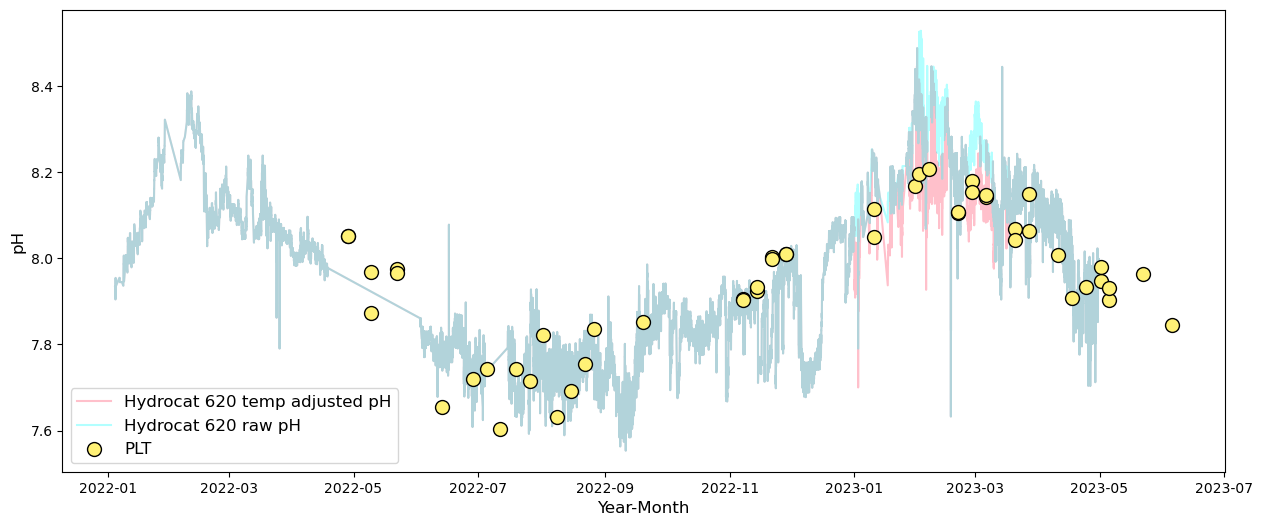

In [91]:
fig, ax = plt.subplots(figsize = [15,6])

ax.plot(hydrocat620_corrected['time'], hydrocat620_corrected['adjusted_ph temp'], color = 'pink', label = 'Hydrocat 620 temp adjusted pH')
ax.plot(hydrocat620_corrected['time'], hydrocat620_corrected['pH total'], alpha = 0.3, color = 'cyan', label = 'Hydrocat 620 raw pH')
ax.scatter(labPLT['time'],labPLT['pH'], 
           marker = 'o', s = 100, edgecolors = 'k', facecolors = '#fff176', label = 'PLT', zorder = 3)
ax.set_ylabel('pH', fontsize = 12)
ax.set_xlabel('Year-Month', fontsize = 12)
ax.legend(fontsize = 12)

# Hydrocat 720

Below, I just plot the raw data, along with the lab samples (with the updated calculation accounting for in situ temperature) and the MV data.

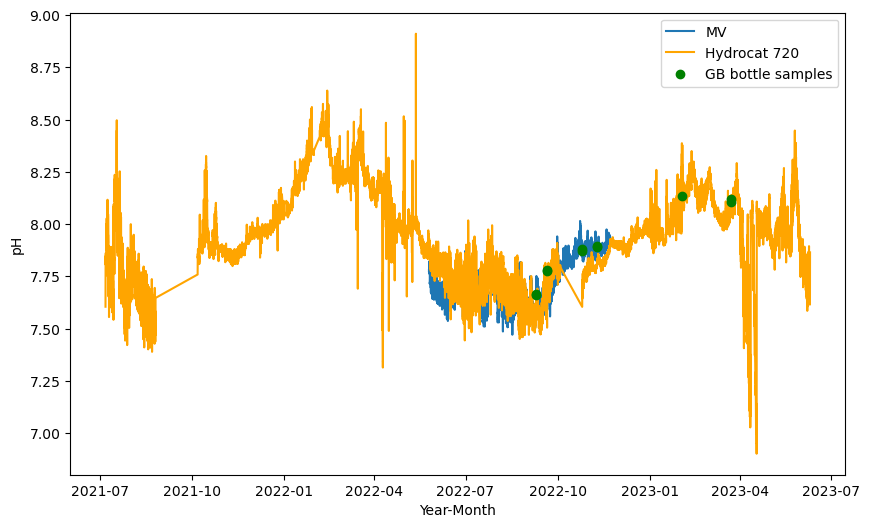

In [92]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(MV['DateTime'], MV['pH total'], label = 'MV')
ax.plot(hydrocat720['DateTime'], hydrocat720['pH total'], color = 'orange', label = 'Hydrocat 720')
ax.scatter(labGB['DateTime'], labGB['pH'], color = 'green', label = 'GB bottle samples', zorder = 3)

# ax.axvline(datetime(2022, 10, 1), color = 'k', lw = 5, label = 'October 1, 2022')
# ax.axvline(datetime(2022, 9, 20), color = 'brown', lw = 5,label = 'September 20, 2022')

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

## Hydrocat 720 corrected

pH behaves oddly (is very low and somewhat erratic) in the first half of April 2023. Perhaps we also drop April 1 - April 18, 2023.

I do not think it is necessary to correct this dataset by temperature.

In [122]:
hydrocat720 = hydrocat720.where(hydrocat720['DateTime'] > datetime(2022,1,1)).dropna()
hydrocat720 = hydrocat720.reset_index(drop=True)
hydrocat720_corrected = rmoutliers_STD(hydrocat720, 'pH total')

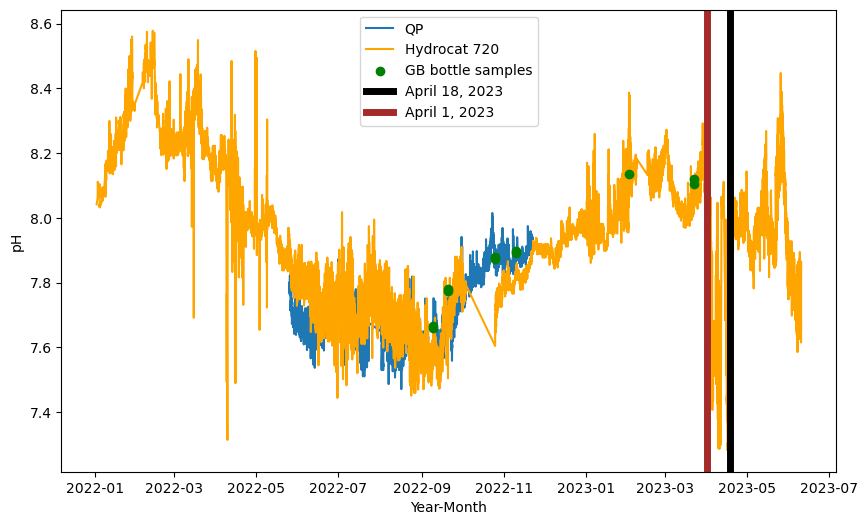

In [124]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(MV['DateTime'], MV['pH total'], label = 'QP')
ax.plot(hydrocat720_corrected['DateTime'], hydrocat720_corrected['pH total'], color = 'orange', label = 'Hydrocat 720')
ax.scatter(labGB['DateTime'], labGB['pH'], color = 'green', label = 'GB bottle samples', zorder = 3)

ax.axvline(datetime(2023, 4, 18), color = 'k', lw = 5, label = 'April 18, 2023')
ax.axvline(datetime(2023, 4, 1), color = 'brown', lw = 5,label = 'April 1, 2023')

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

Below block of code simply drops the measurements taken between April 1 2023 and April 18 2023.

In [126]:
df = hydrocat720_corrected
df = df.reset_index(drop=True)
for ind in df.index:
    if df['DateTime'][ind] <= datetime(2023, 4, 18) and df['DateTime'][ind] > datetime(2023, 4, 1):
        df = df.drop(ind)
df = df.reset_index(drop=True)
hydrocat720_corrected = df

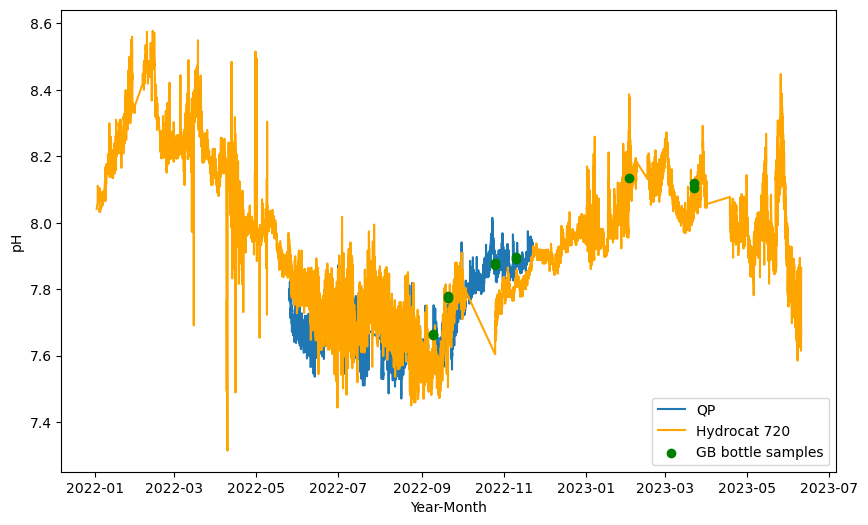

In [127]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(MV['DateTime'], MV['pH total'], label = 'QP')
ax.plot(hydrocat720_corrected['DateTime'], hydrocat720_corrected['pH total'], color = 'orange', label = 'Hydrocat 720')
ax.scatter(labGB['DateTime'], labGB['pH'], color = 'green', label = 'GB bottle samples', zorder = 3)

# ax.axvline(datetime(2023, 4, 15), color = 'k', lw = 5, label = 'April 15, 2023')
# ax.axvline(datetime(2023, 4, 1), color = 'brown', lw = 5,label = 'April 1, 2023')

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

### Hydrocat 720 moving outliers more locally
There still appear to be some deviations in pH in 2022 that are questionable. For instance, there are brief moments in winter when pH measures unseasonably low *very briefly* indicating to me a brief lapse in sensor performance. This is not caught by removing outliers based on what is 2-3 standard deviation from the overall mean, as these deviations would not be as alarming in another season.

Thus, I propose another outlier removal method. Rather than removing values that are 2-3 standard deviations away from the overall mean, we can remove values that are 1 standard deviation away from the 24 hour moving mean. This still uses the overall standard deviation, but since we can safely assume that the diurnal variabily is smaller than the overall variability, I feel comfortable changing the threshold to 1.5 of the overall standard deviations when compared to the moving mean.

In [156]:
def rmoutliers_STD_mvmn(dataframe, var):
    # Calculate the upper and lower limits
    # As defined by 2 standard deviations more/less than mean
    STD = dataframe[var].std()
    # MN = dataframe[var].mean()
    MN = bn.move_mean(dataframe[var], window=96*7, min_count=1)
    LOWER = MN - 1.5*STD
    UPPER = MN + 1.5*STD

    for ind in dataframe.index:
        if dataframe[var][ind] > UPPER[ind]:
            dataframe = dataframe.drop(ind)
        elif dataframe[var][ind] < LOWER[ind]:
            dataframe = dataframe.drop(ind)
    df = dataframe.reset_index(drop=True)
    
    return df

In [157]:
hydrocat720_corrected2 = rmoutliers_STD_mvmn(hydrocat720_corrected, 'pH total')

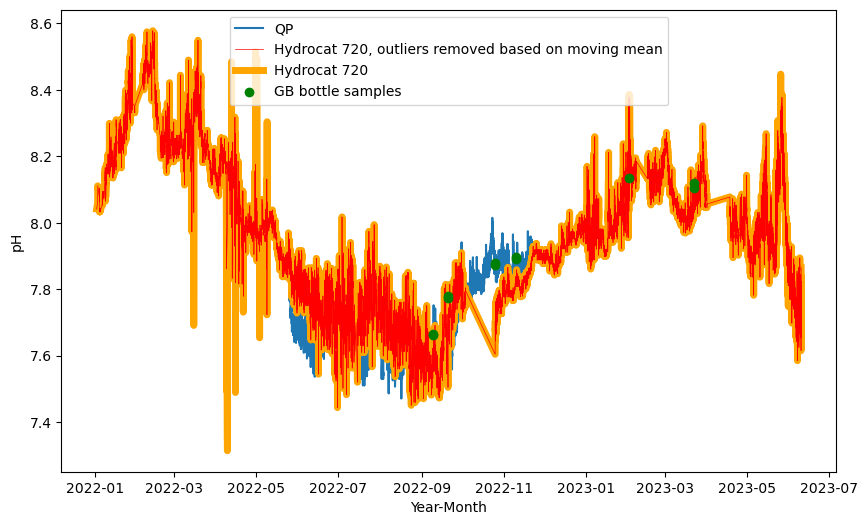

In [158]:
fig, ax = plt.subplots(figsize = [10,6])

ax.plot(MV['DateTime'], MV['pH total'], label = 'QP')
ax.plot(hydrocat720_corrected2['DateTime'], hydrocat720_corrected2['pH total'], color = 'red', lw = 0.5, label = 'Hydrocat 720, outliers removed based on moving mean', zorder = 3)
ax.plot(hydrocat720_corrected['DateTime'], hydrocat720_corrected['pH total'], color = 'orange', lw = 5, label = 'Hydrocat 720')
ax.scatter(labGB['DateTime'], labGB['pH'], color = 'green', label = 'GB bottle samples', zorder = 3)

# ax.axvline(datetime(2023, 4, 15), color = 'k', lw = 5, label = 'April 15, 2023')
# ax.axvline(datetime(2023, 4, 1), color = 'brown', lw = 5,label = 'April 1, 2023')

ax.set_ylabel('pH')
ax.set_xlabel('Year-Month')
ax.legend()

# MV
I have long considered the MV pH to be good as they are. You can see MV plotted with Hydrocat 720. Thus, I will not be doing any QAQC corrections on MV.